In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
import pandas as pd
import seaborn as sn
import re
import math

from mimic3models.metrics import print_metrics_regression

In [3]:
period_bins = [5, 12, 24, 36, 48, 60, 72]

# [4 weeks, 2 weeks, 1 week, 3 days, 2.5 days, 2 days, 1.5 days, 1 day, .5 days]
# remain_bins = [672, 336, 168, 72, 60, 48, 36, 24, 12]
remain_bins = [336, 240, 168, 120, 72, 60, 48, 36, 24, 12]

In [4]:
model_metrics = {}
models = {
    "lin reg" : "/mnt/data01/models/linear_regression/regression/predictions/all.all.csv",
    "phys (reg-full)" : "/mnt/data01/models/cnn/predictions/stay_physio_full_test_result.csv",
    "phys (reg-sm)" : "/mnt/data01/models/cnn/predictions/stay_physio_small_test_result.csv",
    "phys (reg-note-sm)": "/mnt/data01/models/cnn/predictions/stay_both_test_result.csv",
    "lstm (note-reg)" : "/mnt/data01/models/lstm_notes_bert/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs8.ts1.0.partition=none.chunk01.test1.4984.state.csv",
    "lstm (reg)" : "/mnt/data01/models/lstm/regression/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=none.chunk08.test1.2235.state.csv",
    "lstm (bin)" : "/mnt/data01/models/lstm/custom/test_predictions/k_lstm.n64.d0.3.dep1.bs256.ts1.0.partition=custom.chunk14.test1.7325.state.csv",
    "lin reg" : "/mnt/data01/models/linear_regression/regression/predictions/all.all.csv",
    "log reg" : "/mnt/data01/models/linear_regression/logistic/cf_predictions/all.all.l2.C1e-05.csv"
}
model_keys = list(models.keys())
model_keys

['lin reg',
 'phys (reg-full)',
 'phys (reg-sm)',
 'phys (reg-note-sm)',
 'lstm (note-reg)',
 'lstm (reg)',
 'lstm (bin)',
 'log reg']

In [5]:
# Load index file for tests and filter so the models can be compared
path = "/mnt/data01/models/cnn/predictions/"
filename = "both_test_result.csv"
df_cnn = pd.read_csv(os.path.join(path, filename))
df_index = pd.read_csv("/mnt/data01/models/cnn/predictions/test_5_5000_idx.csv")
df_cnn_combine = pd.concat([df_cnn, df_index], axis=1)
df_cnn_combine["EPISODE_ID"] = df_cnn_combine["episode"].apply(lambda x: int(re.findall(r'episode[0-9]', x)[-1][7:]))
df_cnn_combine.rename(columns={"patient_id": "PATIENT_ID", "Hours": "period_length", "Predicted": "prediction", "True" : "y_true"}, inplace=True)
df_cnn_combine["stay"] = df_cnn_combine.apply(lambda x: f"{x.PATIENT_ID}_episode{x.EPISODE_ID}_timeseries.csv", axis=1)
df_cnn_combine["period_length"] = df_cnn_combine["period_length"].apply(lambda x: math.floor(x))
print(df_cnn_combine.describe())
df_cnn_combine.head(2)


       period_length         y_true     prediction            idx  \
count  342890.000000  342890.000000  342890.000000  342890.000000   
mean      140.495576     125.143485     107.776282  171444.500000   
std       198.841326     140.659914      79.809145   98983.961239   
min         5.000000       2.516800     -12.620460       0.000000   
25%        26.000000      27.417000      42.980639   85722.250000   
50%        65.000000      68.210000      85.348030  171444.500000   
75%       171.000000     170.547800     159.698494  257166.750000   
max      1963.000000     670.462400   10540.767578  342889.000000   

          PATIENT_ID     window_idx     EPISODE_ID  
count  342890.000000  342890.000000  342890.000000  
mean    35889.601132     109.564893       1.333792  
std     28574.690391     130.087442       0.876152  
min         4.000000       0.000000       1.000000  
25%     13705.000000      20.000000       1.000000  
50%     25591.000000      57.000000       1.000000  
75%    

,period_length,y_true,prediction,idx,PATIENT_ID,episode,window_idx,EPISODE_ID,stay
0,5,8.3216,95.740395,0,15511,episode1,0,1,15511_episode1_timeseries.csv
1,6,7.3216,196.716431,1,15511,episode1,1,1,15511_episode1_timeseries.csv


In [165]:
## Re-run from here to compare models ##
model = model_keys[len(model_metrics)]
model_metrics[model] = {}
df = pd.read_csv(models[model])
print(model)
df.describe(include="all")

lstm (reg)


,stay,period_length,prediction,y_true
count,525912,525912.000000,525912.000000,525912.000000
unique,6265,NaN,NaN,NaN
top,12805_episode1_timeseries.csv,NaN,NaN,NaN
freq,1988,NaN,NaN,NaN
mean,NaN,143.687375,79.475577,139.145741
std,NaN,202.474764,62.609560,202.464813
min,NaN,5.000000,0.000000,0.000000
25%,NaN,27.000000,24.447373,22.282400
50%,NaN,65.000000,53.176490,60.782000
75%,NaN,173.000000,138.008449,168.562400


In [166]:
# Add patient to the table
df["PATIENT_ID"] = df["stay"].apply(lambda x: int(re.findall(r'[0-9]+_', x)[0][:-1]))
df["EPISODE_ID"] = df["stay"].apply(lambda x: int(re.findall(r'episode[0-9]+_', x)[-1][7:-1]))
df["period_length"] = df["period_length"].apply(lambda x: math.floor(x))

# set the period length to the floor
df["period_length"] = df["period_length"].apply(lambda x: math.floor(x))


In [167]:
# Join to the index file so comparing the same results
print(f"Rows before: {len(df)}")
df_columns = df.columns.tolist()
merge_df = df.merge(df_cnn_combine, how="inner", left_on=["PATIENT_ID", "EPISODE_ID", "period_length"], right_on=["PATIENT_ID", "EPISODE_ID", "period_length"])
df = merge_df[["stay_x", "period_length", "prediction_x", "y_true_x", "PATIENT_ID", "EPISODE_ID"]].copy()
df.rename(columns={"stay_x": "stay", "prediction_x":"prediction", "y_true_x":"y_true"}, inplace=True)
print(f"Rows after: {len(df)}")
df.head(1)

Rows before: 525912
Rows after: 342644


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID
0,10000_episode1_timeseries.csv,5,32.016514,26.8312,10000,1


In [168]:
stay_df = df.groupby(df.stay, as_index=False)["period_length"].agg("max")
print(stay_df.describe())

       period_length
count    4851.000000
mean       79.521336
std       125.482071
min         5.000000
25%        21.000000
50%        41.000000
75%        82.000000
max      1963.000000


[Text(0.5, 0, 'LOS (Hours)')]

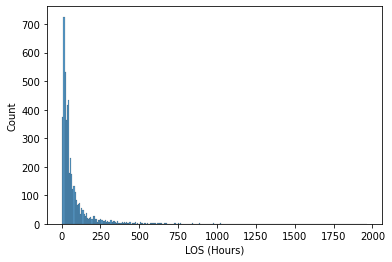

In [169]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

[Text(0.5, 0, 'LOS (Hours)')]

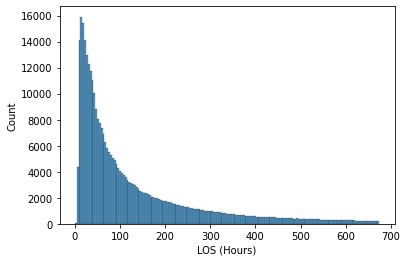

In [170]:
fig = sn.histplot(data=df, x="y_true") #, stat="probability")
fig.set(xlabel='LOS (Hours)')


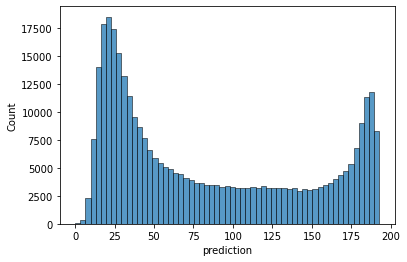

In [171]:
fig = sn.histplot(data=df, x="prediction") #, stat="probability")
# fig.set(xlabel='LOS (Hours)')
# fig.set(xlim=(-12,700))
# fig.get_figure().savefig(f"../plots/{model}-hist-pred.png")

In [172]:
model_metrics[model]["all"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

Custom bins confusion matrix:
[(-1e+18, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, 1e+18)]
[[28309 22327  5239  2159  1134   853   838  1095     4     0]
 [19992 23156  8589  4456  3161  2404  1894  2867     9     0]
 [ 8420 12394  5683  3617  2973  2668  2493  4008     7     0]
 [ 3977  7433  3945  2575  2491  2038  2579  4607     6     0]
 [ 2136  4408  2640  2189  1892  2072  2169  4487    20     0]
 [ 1148  2900  1898  1638  1808  1826  1715  4327     7     0]
 [  732  1838  1364  1409  1461  1516  1529  4033     6     0]
 [  557  1298   954  1070  1225  1150  1492  3826     9     0]
 [ 1042  3828  3581  4184  4555  4676  5876 15059   251     0]
 [  476  1973  2455  2704  3276  3967  4528 14738   335     1]]
Mean absolute deviation (MAD) = 79.2777945535687
Mean squared error (MSE) = 16889.20760547474
Mean absolute percentage error (MAPE) = 81.09662176742381
Cohen kappa score = 0.37995192986489523
F1(micro) = 0.2015093943161323
F1(macro) = 0.1360518251

In [173]:
# Filter quantiles (Windsorization = 94%)
stay_df = stay_df[(stay_df.period_length > stay_df.period_length.quantile(.03)) & \
                  (stay_df.period_length < stay_df.period_length.quantile(.97))]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


       period_length
count    4551.000000
mean       64.237530
std        66.183568
min        10.000000
25%        22.000000
50%        41.000000
75%        78.000000
max       388.000000


[Text(0, 0.5, 'Count Episodes')]

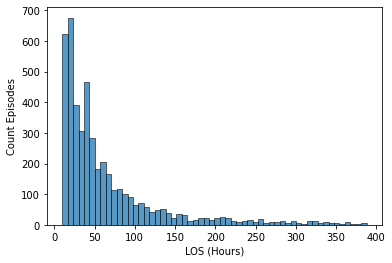

In [174]:
fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
fig.set(xlabel='LOS (Hours)')
fig.set(ylabel='Count Episodes')

In [175]:
model_metrics[model]["windsor"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

Custom bins confusion matrix:
[(-1e+18, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, 1e+18)]
[[28235 21775  5024  1996  1026   778   757   857     0     0]
 [19901 22805  8385  4182  2845  2121  1637  2102     0     0]
 [ 8353 12031  5450  3340  2688  2349  2246  2917     0     0]
 [ 3913  7091  3663  2266  2208  1789  2338  3301     0     0]
 [ 2074  4084  2309  1831  1599  1810  1875  3252     1     0]
 [ 1118  2541  1629  1328  1396  1532  1454  2997     0     0]
 [  697  1614  1154  1041  1097  1198  1200  2592     0     0]
 [  544  1175   712   676   893   891  1163  2209     0     0]
 [  817  2806  2209  2538  2574  2713  3568  5587     1     0]
 [  120   145   189   295   263   238   176    80     0     1]]
Mean absolute deviation (MAD) = 46.43928534089688
Mean squared error (MSE) = 4685.294247697375
Mean absolute percentage error (MAPE) = 83.53682599556834
Cohen kappa score = 0.33164148826423256
F1(micro) = 0.24513561708118253
F1(macro) = 0.14410297

[Text(0.5, 0, 'LOS (Hours)')]

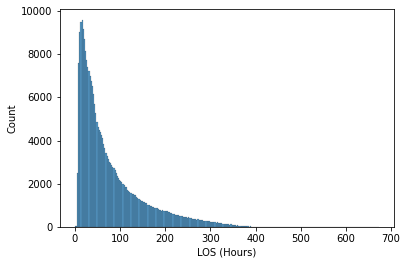

In [176]:
fig = sn.histplot(data=df, x="y_true") #, stat="probability")
fig.set(xlabel='LOS (Hours)')

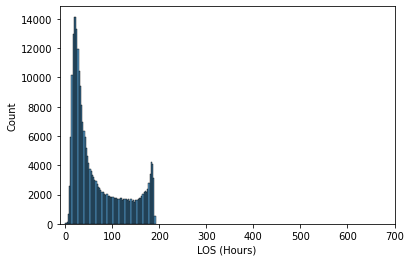

In [177]:
fig = sn.histplot(data=df, x="prediction") #, stat="probability")
fig.set(xlabel='LOS (Hours)')
fig.set(xlim=(-12,700))
fig.get_figure().savefig(f"../plots/{model}-hist-pred-windsor.png")

In [178]:
# Filter only those patiencts that have stay longer than ~ 1 std dev = 60
stay_df = stay_df[stay_df.period_length >= 60]
print(stay_df.describe())
df = df.merge(stay_df[["stay"]], how="inner", left_on="stay", right_on="stay")


       period_length
count    1555.000000
mean      131.330547
std        75.035856
min        60.000000
25%        76.000000
50%       104.000000
75%       161.000000
max       388.000000


In [179]:
# fig = sn.histplot(data=stay_df, x="period_length") #, stat="probability")
# fig.set(xlabel='LOS (Hours)')

In [180]:
model_metrics[model][">60"] = print_metrics_regression(df["y_true"], df["prediction"], extra=True, custom_bin=0, fill_ones=True)

Custom bins confusion matrix:
[(-1e+18, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, 1e+18)]
[[ 8287  7055  1904   829   456   442   503   808     0     0]
 [10862 10968  3947  2254  1879  1578  1445  2102     0     0]
 [ 7692  9978  4464  2853  2491  2301  2227  2917     0     0]
 [ 3882  7009  3614  2230  2192  1788  2338  3301     0     0]
 [ 2073  4070  2285  1817  1593  1810  1875  3252     1     0]
 [ 1118  2529  1620  1306  1390  1532  1454  2997     0     0]
 [  697  1607  1153  1040  1097  1198  1200  2592     0     0]
 [  544  1175   712   676   893   891  1163  2209     0     0]
 [  817  2800  2199  2538  2574  2713  3568  5587     1     0]
 [  120   145   189   295   263   238   176    80     0     1]]
Mean absolute deviation (MAD) = 57.14364272419061
Mean squared error (MSE) = 6172.390915963088
Mean absolute percentage error (MAPE) = 78.8953759839948
Cohen kappa score = 0.25243680855216366
F1(micro) = 0.16878042697785098
F1(macro) = 0.124656321

In [181]:
# Slice the data by period snapshots and test at each interval
df_list = []

period_df = df[df.period_length <= period_bins[0]].copy()
period_df["period_bin"] = period_bins[0]
df_list.append(period_df)

for bin in period_bins[1:]:
    period_df = df[df.period_length == bin].copy()
    period_df["period_bin"] = bin
    df_list.append(period_df)

period_df = pd.concat(df_list)
print(f"Period bins (hours): {period_bins}")
period_df.head(3)

Period bins (hours): [5, 12, 24, 36, 48, 60, 72]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,period_bin
0,10011_episode1_timeseries.csv,5,57.529247,327.4168,10011,1,5
249,10042_episode1_timeseries.csv,5,58.135586,190.3960,10042,1,5
419,10094_episode1_timeseries.csv,5,43.461933,93.4336,10094,1,5


In [182]:
period_group_df = period_df.groupby("period_bin", as_index=False)["stay"].count()
period_group_df.head(20)

,period_bin,stay
0,5,1518
1,12,1509
2,24,1510
3,36,1503
4,48,1525
5,60,1519
6,72,1201


[Text(0.5, 0, 'With LOS greater than (Hours)'), Text(0, 0.5, 'Count')]

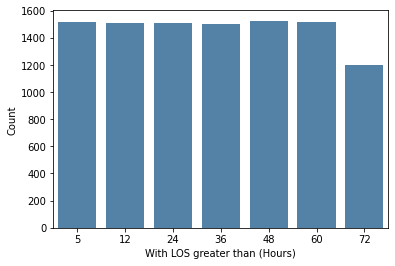

In [183]:
fig = sn.barplot(data=period_group_df, x="period_bin", y="stay", color="steelblue")
fig.set(xlabel='With LOS greater than (Hours)', ylabel='Count')


In [184]:
# # Bivariate histogram (heatmap)
# fig = sn.histplot(data=period_df, x="prediction", y="y_true") #, stat="probability")
# fig.set(xlabel='Predicted Remaining LOS (Hours)')
# fig.set(ylabel='Actual Remaining LOS (Hours)')
# fig.set(xlim=(-12,600))

In [185]:
period_metrics = []
for bin in period_bins:
    metric_df = period_df[period_df.period_bin == bin].copy()
    print(f"\nMetrics at {bin} hours")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    metrics = print_metrics_regression(metric_df["y_true"], metric_df["prediction"], custom_bin=2, fill_ones=True)

    metrics["bin"] = bin
    metrics["model"] = model
    period_metrics.append(metrics)

if 'period_metrics_df' in locals():
    period_metrics_df = pd.concat([period_metrics_df, pd.DataFrame(period_metrics)])
else:
    period_metrics_df = pd.DataFrame(period_metrics)    


Metrics at 5 hours
Unique episodes: 1517
Unique patients: 1385
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[  1   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   1  35  52  59  41  48   0   0]
 [  1   2  81 193 211 196 221   0   0]
 [  0   0  13  43  56  97 124   1   0]
 [  0   0   1   5   5  15  20   0   1]]
Mean absolute deviation (MAD) = 78.78037979314888
Mean squared error (MSE) = 11613.920511264212
Mean absolute percentage error (MAPE) = 48.11482978201732
Cohen kappa score = 0.022362003075765524

Metrics at 12 hours
Unique episodes: 1508
Unique patients: 1382
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[  1   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0

[Text(0, 0.5, 'Mean Squared Error')]

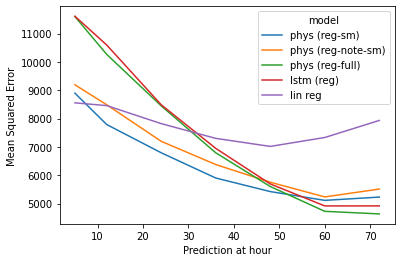

In [186]:
period_metrics_df = period_metrics_df.sort_values(by=["model","bin"], ascending=False)
fig = sn.lineplot(data=period_metrics_df, x="bin", y="mse", hue="model", sort=False)
fig.set(xlabel='Prediction at hour')
fig.set(ylabel='Mean Squared Error')

In [187]:
# Slice for Remaining bin statistics
df_list = []

for bin in remain_bins:
    remain_df = df[(df.y_true >= bin - 1) & (df.y_true < bin)].copy()
    remain_df["remain_bin"] = bin
    df_list.append(remain_df)

remain_df = pd.concat(df_list)
print(f"Remaining bins (hours): {remain_bins}")
remain_df.head(3)

Remaining bins (hours): [336, 240, 168, 120, 72, 60, 48, 36, 24, 12]


,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,remain_bin
10139,12903_episode1_timeseries.csv,47,159.969879,335.6368,12903,1,336
11708,1338_episode1_timeseries.csv,30,70.037560,335.7816,1338,1,336
17396,14947_episode1_timeseries.csv,45,131.773514,335.8248,14947,1,336


In [188]:
remain_group_df = remain_df.groupby("remain_bin", as_index=False)["stay"].count()
remain_group_df.head(10)

,remain_bin,stay
0,12,1087
1,24,1384
2,36,1452
3,48,1482
4,60,1515
5,72,1286
6,120,656
7,168,386
8,240,190
9,336,47


[Text(0.5, 0, 'LOS Remaining (Hours)'), Text(0, 0.5, 'Count')]

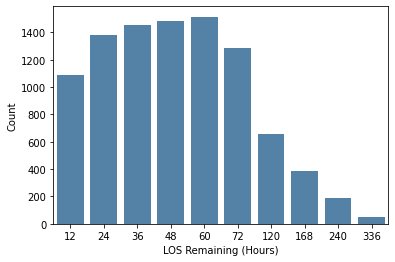

In [189]:
fig = sn.barplot(data=remain_group_df, x="remain_bin", y="stay", color="steelblue")
fig.set(xlabel='LOS Remaining (Hours)', ylabel='Count')

In [190]:
# # Bivariate histogram (heatmap)
# fig = sn.histplot(data=remain_df, x="prediction", y="y_true") #, stat="probability")
# fig.set(xlabel='Predicted Remaining LOS (Hours)')
# fig.set(ylabel='Actual Remaining LOS (Hours)')
# fig.set(xlim=(-12,400))

In [191]:
print(f'Unique episodes: {len(remain_df.stay.unique())}')
print(f'Unique patients: {len(remain_df.PATIENT_ID.unique())}')

model_metrics[model]["remain"] = print_metrics_regression(remain_df["y_true"], remain_df["prediction"], extra=True, custom_bin=2, fill_ones=True)

Unique episodes: 1552
Unique patients: 1416
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 42 438 267 105  56  30 112  38   0]
 [ 55 433 321 171  86  63 195  61   0]
 [ 42 405 303 147  91  72 311  82   0]
 [ 45 358 278 158 101  72 358 113   0]
 [ 22 316 259 163 116  80 438 122   0]
 [ 17 209 227 138  91  89 391 125   0]
 [  8  90  96  82  59  57 420 231   0]
 [  1   6  13  15  14  14 113  62   0]
 [  0   0   0   0   0   0   0   0   1]]
Mean absolute deviation (MAD) = 42.57755845134423
Mean squared error (MSE) = 3617.6769016148073
Mean absolute percentage error (MAPE) = 102.64820083940747
Cohen kappa score = 0.20985932818763675
F1(micro) = 0.1710554034126817
F1(macro) = 0.2435799679460776
AUC = nan
Recall = 0.1710554034126817
Accuracy = 0.1710554034126817


In [192]:
remain_metrics = []
for bin in remain_bins:
    metric_df = remain_df[remain_df.remain_bin == bin].copy()
    if len(metric_df) == 0:
        continue

    print(f"\nMetrics where {bin} hours remaining")
    print(f'Unique episodes: {len(metric_df.stay.unique())}')
    print(f'Unique patients: {len(metric_df.PATIENT_ID.unique())}')
    print(f'Predictions: {len(metric_df)}')
    metrics = print_metrics_regression(metric_df["y_true"], metric_df["prediction"], extra=True, custom_bin=2, fill_ones=True)
    metrics["bin"] = bin
    metrics["model"] = model
    remain_metrics.append(metrics)

if 'remain_metrics_df' in locals():
    remain_metrics_df = pd.concat([remain_metrics_df, pd.DataFrame(remain_metrics)])
else:
    remain_metrics_df = pd.DataFrame(remain_metrics)    


Metrics where 336 hours remaining
Unique episodes: 47
Unique patients: 46
Predictions: 47
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, 3), (3, 7), (7, 14), (14, 1e+18)]
[[ 1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 1  0  0  4  4  5 29  5  0]
 [ 0  0  0  0  0  0  0  0  1]]
Mean absolute deviation (MAD) = 230.40696987234045
Mean squared error (MSE) = 55061.46392120141
Mean absolute percentage error (MAPE) = 68.65274420228273
Cohen kappa score = 0.33139722491126167
F1(micro) = 0.23214285714285715
F1(macro) = 0.5413603325958773
AUC = nan
Recall = 0.23214285714285715
Accuracy = 0.23214285714285715

Metrics where 240 hours remaining
Unique episodes: 190
Unique patients: 179
Predictions: 190
Custom bins confusion matrix:
[(-1e+18, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5,

In [193]:
remain_metrics_df.head(20)

,mad,mse,mape,kappa,f1_micro,f1_macro,auc,recall,accuracy,bin,model
0,201.971859,43280.853730,60.177449,0.462687,0.370370,0.645977,NaN,0.370370,0.370370,336,phys (reg-sm)
1,91.887619,11941.041364,38.347492,0.212683,0.500000,0.510725,NaN,0.500000,0.500000,240,phys (reg-sm)
2,59.264636,5215.823646,35.358381,0.102141,0.356201,0.442148,NaN,0.356201,0.356201,168,phys (reg-sm)
3,61.179640,4859.435347,51.144651,0.054919,0.344340,0.375029,NaN,0.344340,0.344340,120,phys (reg-sm)
4,50.187268,4593.663165,70.087764,0.018618,0.088307,0.357735,NaN,0.088307,0.088307,72,phys (reg-sm)
5,48.347663,5030.530483,81.128280,0.012048,0.136424,0.272759,NaN,0.136424,0.136424,60,phys (reg-sm)
6,45.844790,19228.662651,96.355307,0.009376,0.239333,0.346305,NaN,0.239333,0.239333,48,phys (reg-sm)
7,52.663196,20179.179504,147.972625,0.005123,0.037609,0.307750,NaN,0.037609,0.037609,36,phys (reg-sm)
8,60.624713,20778.691897,256.984344,0.002995,0.006127,0.195630,NaN,0.006127,0.006127,24,phys (reg-sm)
9,65.568455,6057.685622,565.457333,0.002504,0.006839,0.235510,NaN,0.006839,0.006839,12,phys (reg-sm)


[(-12.0, 60000.0)]

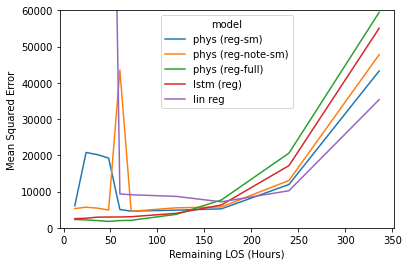

In [194]:
remain_metrics_df = remain_metrics_df.sort_values(by=["model","bin"], ascending=False)
fig = sn.lineplot(data=remain_metrics_df, x="bin", y="mse", hue="model", sort=False)
fig.set(xlabel='Remaining LOS (Hours)')
fig.set(ylabel='Mean Squared Error')
fig.set(ylim=(-12,60000))

In [204]:
import json
with open(f"../plots/metrics_{len(model_metrics)}.json", "w") as f:
    json.dump(model_metrics, f)


In [196]:
## TESTS
box_bins = [24, 48, 72, 168, 336] 
test_df = remain_df[remain_df.remain_bin.isin(box_bins)].copy()

# print(f"\nMetrics where {bin} hours remaining")
# print(f'Unique episodes: {len(test_df.stay.unique())}')
# print(f'Unique patients: {len(test_df.PATIENT_ID.unique())}')
# print(f'Predictions: {len(test_df)}')
# out = print_metrics_regression(test_df["y_true"], test_df["prediction"], extra=True, custom_bin=2, fill_ones=True)

In [197]:
test_df["deviation"] = test_df.apply(lambda x: x.prediction - x.y_true, axis=1)
test_df.describe(include="all")

,stay,period_length,prediction,y_true,PATIENT_ID,EPISODE_ID,remain_bin,deviation
count,4585,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000,4585.000000
unique,1550,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,27800_episode1_timeseries.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,96.478735,66.785511,60.043541,36860.780807,1.360523,60.541767,6.741970
std,NaN,75.579307,54.374365,47.346681,28702.087639,0.949540,47.340912,60.446079
min,NaN,5.000000,0.000000,23.000000,6.000000,1.000000,24.000000,-323.604749
25%,NaN,44.000000,24.014122,23.820800,13926.000000,1.000000,24.000000,-26.522171
50%,NaN,73.000000,42.531269,47.607200,26532.000000,1.000000,48.000000,-1.882851
75%,NaN,128.000000,103.003723,71.449600,60054.000000,1.000000,72.000000,33.793218


In [198]:
test_df = test_df[(test_df.deviation < 400) & (test_df.deviation > -400)]

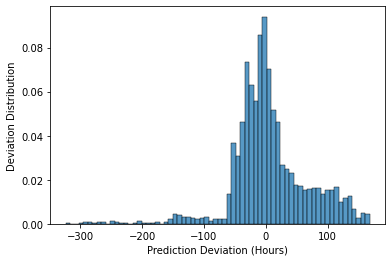

In [199]:
fig = sn.histplot(data=test_df, x="deviation", stat="probability")
fig.set(xlabel='Prediction Deviation (Hours)')
fig.set(ylabel='Deviation Distribution')
fig.get_figure().savefig(f"../plots/{model}-hist-remain.png")

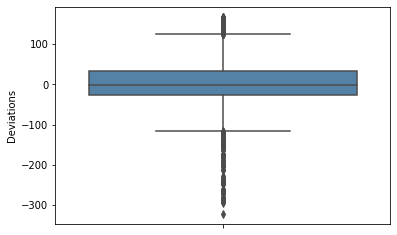

In [200]:
fig = sn.boxplot(y="deviation", data=test_df, color="steelblue")
fig.set(ylabel='Deviations')
fig.get_figure().savefig(f"../plots/{model}-box-remain-all.png")

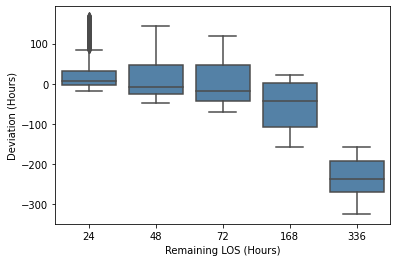

In [201]:
fig = sn.boxplot(y="deviation", x="remain_bin", data=test_df, color="steelblue")
fig.set(ylabel='Deviation (Hours)')
fig.set(xlabel='Remaining LOS (Hours)')
fig.get_figure().savefig(f"../plots/{model}-box-remain.png")